# First Experiment: Using the MAB ε-greedy algorithm to study the exploration-exploitation tradeoff of node loads
## Experimental Ideas

1. Generate load data of nodes.
2. Implement the ε-greedy dobby slot machine algorithm.
3. Record and plot regret values.
4. Calculate and plot top-k accuracy. (Visualisation results)

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

## Experiment 1: the means are very close to all nodes
### Step 1: Generate load data
We generate T = 1000 load values for each node and generate load data using Gaussian distribution.

The mu and std of means are set to 5 and 0.5 respectively, and the standard deviation of the load is set to 1.

In [9]:
# Set parameters
N = 20  # Number of nodes
T = 1000  # Number of data points per node

# Load parameters
load_means = np.random.normal(15, 0.5, N)  # Load means are close to each other
load_std = 1  # Load standard deviation

# Generate load data
loads = [np.random.normal(load_means[i], load_std, T) for i in range(N)]

# Calculate the average load for each node
mean_loads = [np.mean(load) for load in loads]

# Output the average load for each node
for i in range(N):
    print(f'Node {i + 1}: Mean Load = {mean_loads[i]:.2f}')


Node 1: Mean Load = 15.33
Node 2: Mean Load = 15.30
Node 3: Mean Load = 15.56
Node 4: Mean Load = 14.42
Node 5: Mean Load = 15.48
Node 6: Mean Load = 15.46
Node 7: Mean Load = 14.53
Node 8: Mean Load = 15.79
Node 9: Mean Load = 14.82
Node 10: Mean Load = 14.67
Node 11: Mean Load = 14.79
Node 12: Mean Load = 14.94
Node 13: Mean Load = 15.85
Node 14: Mean Load = 14.86
Node 15: Mean Load = 15.95
Node 16: Mean Load = 15.15
Node 17: Mean Load = 14.57
Node 18: Mean Load = 15.04
Node 19: Mean Load = 15.94
Node 20: Mean Load = 14.66


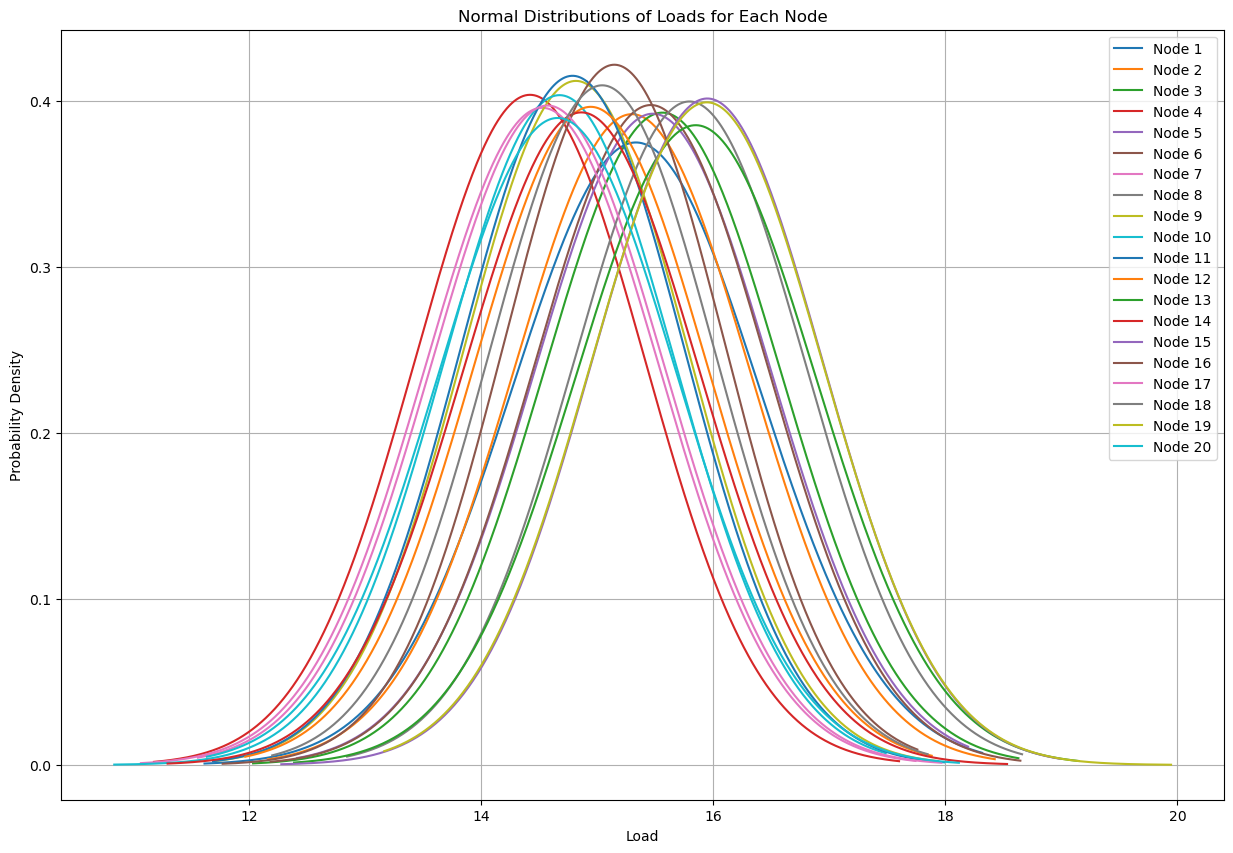

In [10]:
# Plot the normal distributions for each node
plt.figure(figsize=(15, 10))

for i in range(N):
    # Fit a normal distribution to the data
    x = np.linspace(min(loads[i]), max(loads[i]), 1000)
    y = norm.pdf(x, np.mean(loads[i]), np.std(loads[i]))

    plt.plot(x, y, label=f'Node {i + 1}')

plt.title('Normal Distributions of Loads for Each Node')
plt.xlabel('Load')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

### Step 2: Implement the ε-greedy algorithm and record regret values

In [11]:
def epsilon_greedy(loads, epsilon, T):
    N = len(loads)
    rewards = np.zeros(N)
    counts = np.zeros(N)
    regrets = []

    for t in range(T):
        if np.random.rand() < epsilon:
            # Exploration: randomly select a node
            node = np.random.randint(0, N)
        else:
            # Exploitation: select the node with the highest average reward
            node = np.argmax(rewards / (counts + 1e-5))
                
        # Get the reward
        load = loads[node][t]
        reward = 1 / (1 + load)

        # Update rewards and counts
        rewards[node] += reward
        counts[node] += 1

        # Calculate regret (difference between selected node's load and the optimal node's load)
        optimal_node = np.argmin([np.mean(load) for load in loads])
        regret = np.mean(loads[node]) - np.mean(loads[optimal_node])
        regrets.append(regret)

    return np.cumsum(regrets)

# Run the ε-greedy algorithm and record regret
epsilon_values = [0.01, 0.1, 0.2]
all_regrets = {}

for epsilon in epsilon_values:
    all_regrets[epsilon] = epsilon_greedy(loads, epsilon, T)


### Step 3: Plot Cumulative Regret Over Time

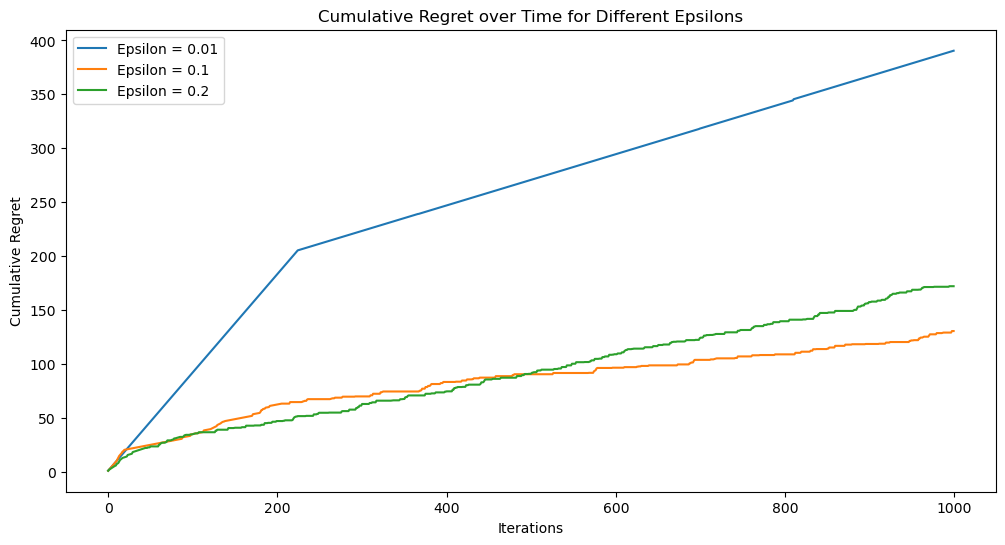

In [12]:
plt.figure(figsize=(12, 6))
for epsilon in epsilon_values:
    plt.plot(all_regrets[epsilon], label=f'Epsilon = {epsilon}')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time for Different Epsilons')
plt.legend()
plt.show()


#### Analysis and interpretation
The cumulative regret value is used to evaluate the performance and efficiency of the algorithm in the decision making process.

After several trials, the image was found to be unstable. The trend depends not only on the setting of the Epsilon value but also on the randomly initialised node load values

Here are some typical trends of the curves:
1. the curve continues to rise sharply and never converges, indicating that insufficient exploration leads to cumulative losses over time and the optimal node is never found.
2. the curve rises rapidly in the early stages and then levels off (converges). Indicates that the algorithm did not explore effectively in the early stages, resulting in a rapid accumulation of regret values, but eventually found a suitable node.
3. The curve is levelling off (converging) after a long period of slow rise. Indicates that the algorithm did not explore effectively for a longer period of time, but exploitation, thus accumulating regret values, but eventually found the right node.

After several attempts, it was found that the curve trend is very unstable when Epsilon == 0.01. It is sometimes the best, sometimes the worst, and often has a very different trend from the other two curves; whereas for the two curves with Epsilon equal to 0.1 and 0.2, respectively, in the vast majority of cases the two behave very similarly. Sometimes the curve with a value of 0.1 converges earlier and has a lower cumulative regret than the curve with a value of 0.2. 

### Step 4: Calculate and Plot Top-k Accuracy

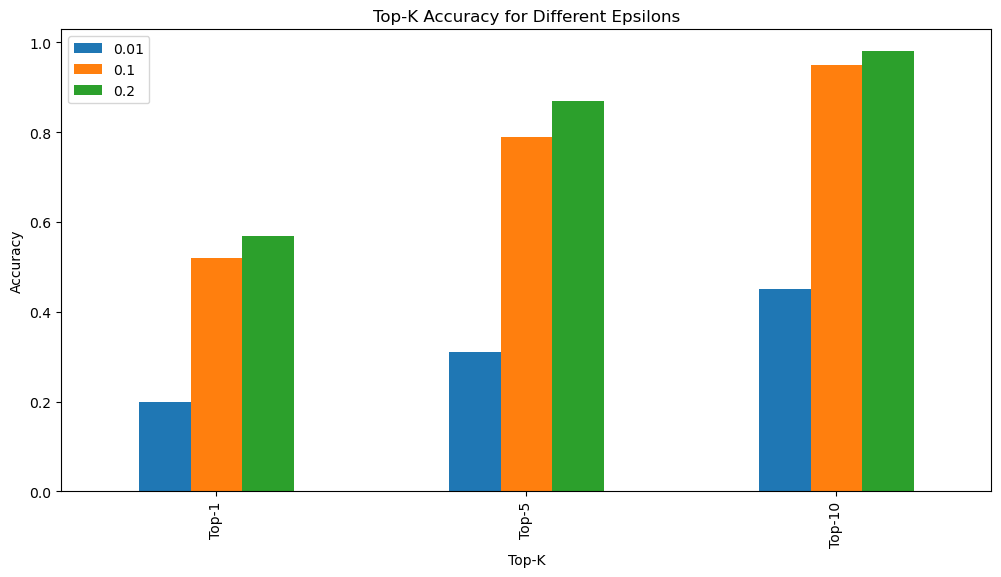

In [13]:
def top_k_accuracy(loads, epsilon, T, k):
    N = len(loads)
    rewards = np.zeros(N)
    counts = np.zeros(N)

    for t in range(T):
        if np.random.rand() < epsilon:
            node = np.random.randint(0, N)
        else:
            node = np.argmax(rewards / (counts + 1e-5))

        load = loads[node][t]
        reward = 1 / (1 + load)
        rewards[node] += reward
        counts[node] += 1

    # Calculate top-k nodes
    top_k_nodes = np.argsort(rewards / (counts + 1e-5))[-k:]
    optimal_node = np.argmin([np.mean(load) for load in loads])

    return optimal_node in top_k_nodes

# Calculate top-1, top-5, and top-10 accuracy
top_k_values = [1, 5, 10]
accuracy_results = {epsilon: [] for epsilon in epsilon_values}

for epsilon in epsilon_values:
    for k in top_k_values:
        accuracy = np.mean([top_k_accuracy(loads, epsilon, T, k) for _ in range(100)])
        accuracy_results[epsilon].append(accuracy)

# Convert accuracy data to DataFrame
import pandas as pd
accuracy_df = pd.DataFrame(accuracy_results, index=['Top-1', 'Top-5', 'Top-10'])

# Visualize Top-K accuracy
accuracy_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Top-K')
plt.ylabel('Accuracy')
plt.title('Top-K Accuracy for Different Epsilons')
plt.show()


#### Analysis and interpretation
Top-K Accuracy is the frequency with which an algorithm is able to include the optimal node (or the optimal K nodes) among the first K selected nodes in a multi-armed slot machine problem. By calculating the Top-K Accuracy, we can evaluate the performance of the algorithm in finding the optimal solution or a near-optimal solution.

After several repetitions of the experiment, it is found that the top-k accuracy distributions are similar for different epsilon values, although the initialised random numbers are different. The analysis is as follows:

Under the current experimental conditions, the top-k accuracy is always proportional to the epsilon value taken. Usually the results for the 0.1 and 0.2 values are very similar and both are much better than the 0.01 value.

This indicates that the differences between nodes are moderate and require some exploration to discover the optimal node.

## Experiment 2: The means of the nodes are very far away to all nodes
The mu and std of means are set to 5 and 15 respectively, and the standard deviation of the load is set to 1. The rest of the parameters are the same as in the first experiment.

In [19]:
# Set parameters
N = 20  # Number of nodes
T = 1000  # Number of data points per node

# Load parameters
load_means = np.random.normal(15, 15, N)  # Load means are close to each other
load_std = 1  # Load standard deviation

# Generate load data
loads = [np.random.normal(load_means[i], load_std, T) for i in range(N)]

# Calculate the average load for each node
mean_loads = [np.mean(load) for load in loads]

# Output the average load for each node
for i in range(N):
    print(f'Node {i + 1}: Mean Load = {mean_loads[i]:.2f}')


Node 1: Mean Load = 23.29
Node 2: Mean Load = -17.01
Node 3: Mean Load = 30.42
Node 4: Mean Load = -5.42
Node 5: Mean Load = 14.55
Node 6: Mean Load = 1.45
Node 7: Mean Load = 27.13
Node 8: Mean Load = 29.93
Node 9: Mean Load = -1.06
Node 10: Mean Load = 2.01
Node 11: Mean Load = -0.86
Node 12: Mean Load = 22.10
Node 13: Mean Load = 17.42
Node 14: Mean Load = 13.77
Node 15: Mean Load = 21.74
Node 16: Mean Load = 19.17
Node 17: Mean Load = 20.40
Node 18: Mean Load = 35.18
Node 19: Mean Load = 7.96
Node 20: Mean Load = 22.27


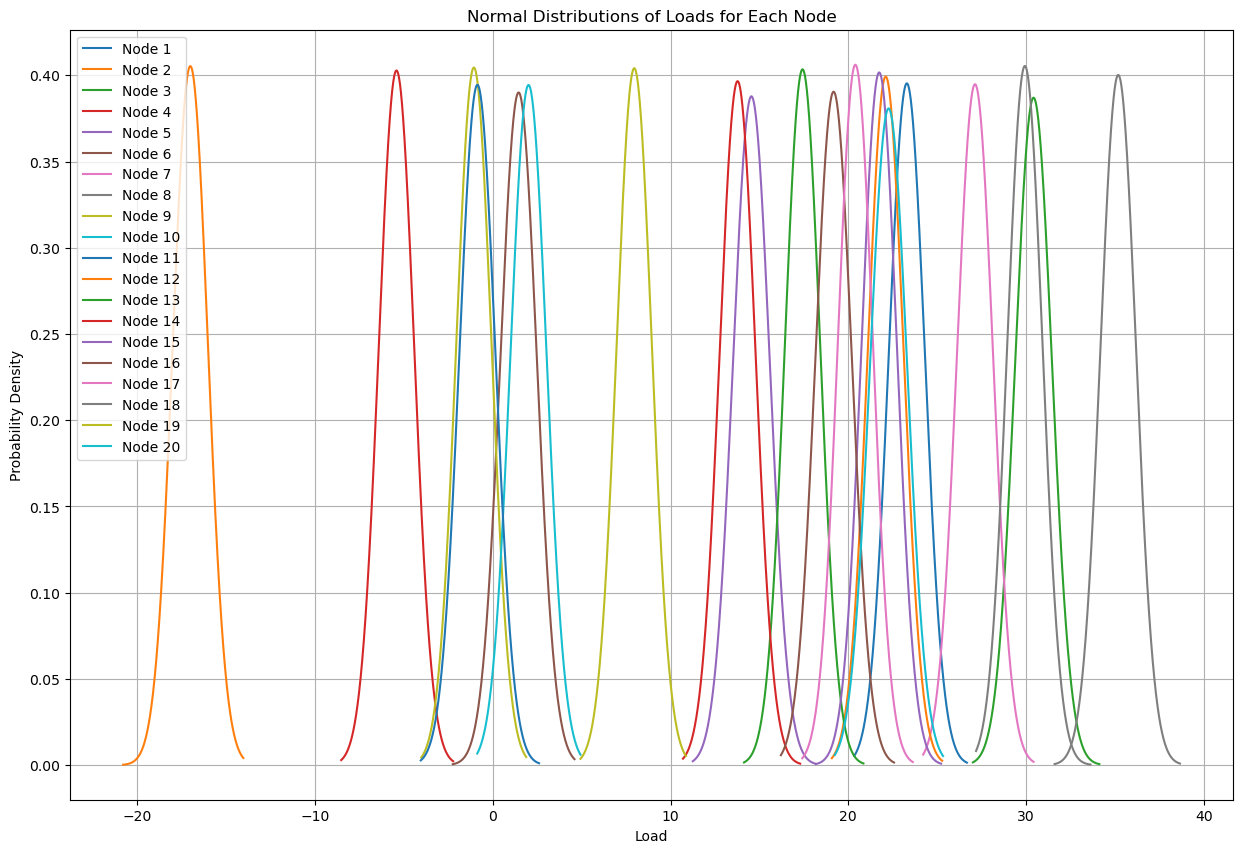

In [20]:
# Plot the normal distributions for each node
plt.figure(figsize=(15, 10))

for i in range(N):
    # Fit a normal distribution to the data
    x = np.linspace(min(loads[i]), max(loads[i]), 1000)
    y = norm.pdf(x, np.mean(loads[i]), np.std(loads[i]))

    plt.plot(x, y, label=f'Node {i + 1}')

plt.title('Normal Distributions of Loads for Each Node')
plt.xlabel('Load')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Run the ε-greedy algorithm and record regret
epsilon_values = [0.01, 0.1, 0.2]
all_regrets = {}

for epsilon in epsilon_values:
    all_regrets[epsilon] = epsilon_greedy(loads, epsilon, T)


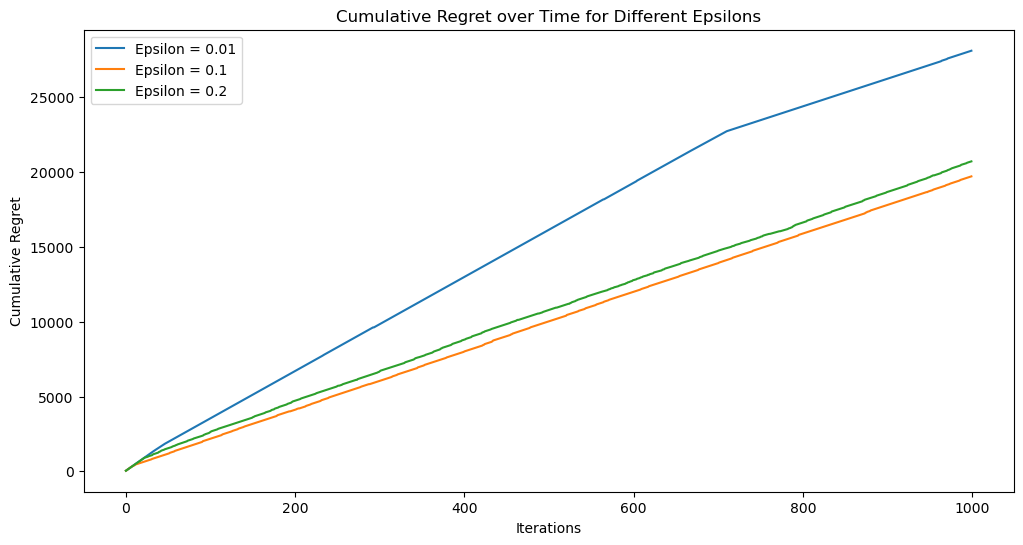

In [22]:
plt.figure(figsize=(12, 6))
for epsilon in epsilon_values:
    plt.plot(all_regrets[epsilon], label=f'Epsilon = {epsilon}')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Time for Different Epsilons')
plt.legend()
plt.show()


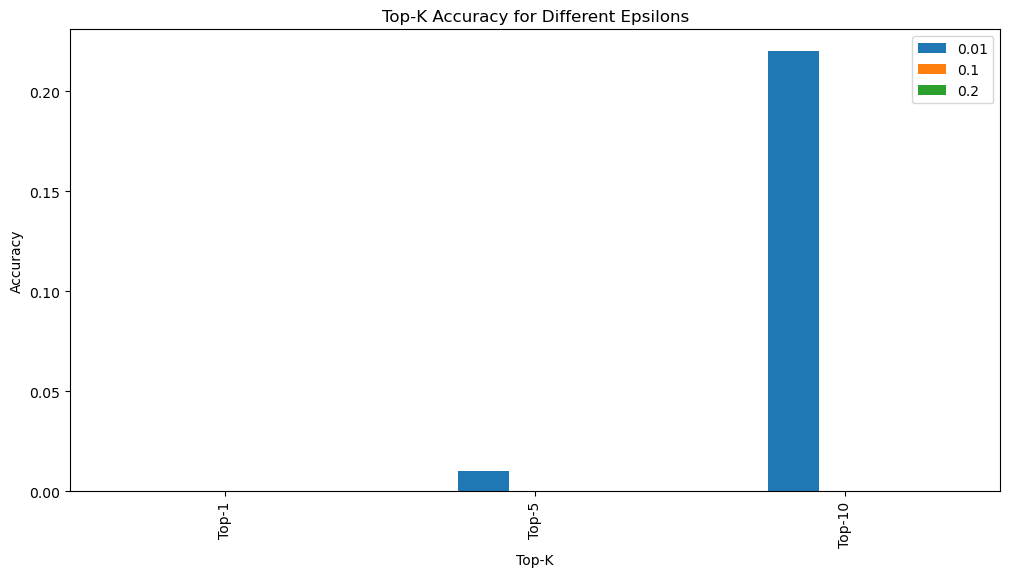

In [23]:
# Calculate top-1, top-5, and top-10 accuracy
top_k_values = [1, 5, 10]
accuracy_results = {epsilon: [] for epsilon in epsilon_values}

for epsilon in epsilon_values:
    for k in top_k_values:
        accuracy = np.mean([top_k_accuracy(loads, epsilon, T, k) for _ in range(100)])
        accuracy_results[epsilon].append(accuracy)

# Convert accuracy data to DataFrame
import pandas as pd
accuracy_df = pd.DataFrame(accuracy_results, index=['Top-1', 'Top-5', 'Top-10'])

# Visualize Top-K accuracy
accuracy_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Top-K')
plt.ylabel('Accuracy')
plt.title('Top-K Accuracy for Different Epsilons')
plt.show()


#### Analysis and interpretation
The results of the second experiment are very different from the first experiment. The cumulative regret values are much higher than in the first experiment, and the trends of the curves are very different. The top-k accuracy values are also much lower than in the first experiment.

The results of the second experiment were very different from the first. The cumulative regret values were much higher than in the first experiment, and the trend of the curve kept rising without converging. The differences between the three different epsilon values were not significant, with the 0.01 value performing slightly better than the other two for most of the replicates conducted. The 0.1 and 0.2 values continue to perform very similarly.

The accuracy values for top-k were also much lower than in the first experiment. The top-1, top-5, and top-10 accuracies for the 0.1 and 0.2 values were consistently 0 for many repetitions of the experiment, while the 0.01 values were sometimes not 0 for top-5 and top-10, but their absolute values were still very low, around 2%-10%.

This suggests that the overall exploration-exploitation tradeoff is more difficult to control when the load difference between nodes becomes larger.

## Summary
The two experiments show that in the case of a fixed value of epsilon:

- In the case of small mean differences, where the loads of all nodes are closer, high exploration rates (ε = 0.1 and ε = 0.2) help the algorithm to discover slightly better nodes, although the overall effect is not as good as with low exploration rates.

- With a large mean difference, the optimal node significantly outperforms other nodes, and the low exploration rate (ε = 0.01) helps the algorithm make better use of the known information by selecting the optimal node frequently and reducing cumulative regret.

The results of the experiments are more counter-intuitive. Theoretically, for the epsilon-greedy algorithm, it should be the case that the larger the difference between the delayed means of the nodes, the better the performance, as better values can be more obviously selected. But the results are the opposite.

A possible explanation is that in the case of a large mean difference, although the optimal nodes are easily distinguishable, the high exploration rate of the algorithm may lead to frequent selection of suboptimal nodes, affecting the overall performance.

I will investigate the issue in further experiments.